In [16]:
#Importing Libraries
import warnings
import scipy.stats
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook
from sklearn.metrics import f1_score
import xgboost
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import os
from bayes_opt import BayesianOptimization
print(os.listdir("../input"))

['sample_submission.csv', 'test.csv', 'train.csv']


In [17]:
#Reading Data
df=pd.read_csv("../input/train.csv")
del df['id']
print(df.shape)
display(df.head())

(188318, 131)


,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [18]:
#Reading Test data
test=pd.read_csv("../input/test.csv")
idx=test['id']
del test['id']
print(test.shape)
display(test.head())

(125546, 130)


,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,...,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,A,B,A,A,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,A,D,C,C,E,C,D,T,H,G,A,A,G,E,I,L,K,BI,BC,A,J,AX,A,Q,HG,0.321594,0.299102,0.246911,0.402922,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,A,D,D,D,E,A,A,P,B,D,A,A,G,G,G,F,B,BI,CO,E,G,X,A,L,HK,0.634734,0.620805,0.654310,0.946616,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,A,B,A,B,B,A,B,A,B,B,A,B,B,B,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,A,...,A,A,D,D,C,E,E,A,D,G,Q,A,D,D,E,J,G,A,BI,CS,C,U,AE,A,K,CK,0.290813,0.737068,0.711159,0.412789,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,...,G,H,D,D,C,E,E,D,T,G,A,A,D,E,E,I,K,K,BI,CR,A,AY,AJ,A,P,DJ,0.268622,0.681761,0.592681,0.354893,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,A,D,B,D,E,A,A,P,A,A,A,A,F,E,G,E,B,AB,EG,A,E,I,C,J,HA,0.553846,0.299102,0.263570,0.696873,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


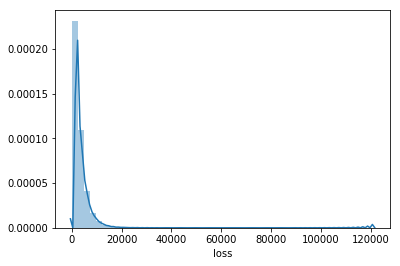

In [19]:
#Plot target
sns.distplot(df.loss)

In [20]:
#Categorical Interactions Top50
cat_int=['cat12|cat80', 'cat79|cat80', 'cat1|cat12|cat80',
       'cat12|cat80|cat81', 'cat12|cat79|cat80', 'cat1|cat80',
       'cat103|cat12|cat80', 'cat57|cat80', 'cat12|cat72|cat80',
       'cat1|cat103|cat80', 'cat57|cat79|cat80', 'cat1|cat80|cat81',
       'cat12|cat57|cat80', 'cat2|cat57|cat80', 'cat10|cat80',
       'cat12|cat81', 'cat103|cat12', 'cat1|cat12', 'cat1|cat114|cat80',
       'cat10|cat103|cat80', 'cat1|cat111|cat80', 'cat10|cat111|cat80',
       'cat12|cat53', 'cat1|cat103', 'cat12|cat53|cat80',
       'cat10|cat101|cat80', 'cat12|cat53|cat81', 'cat12|cat79',
       'cat1|cat81', 'cat2|cat80|cat81', 'cat81|cat87', 'cat12|cat72',
       'cat103|cat111', 'cat1|cat72', 'cat10|cat114|cat81', 'cat4|cat5',
       'cat103|cat111|cat80', 'cat10|cat72|cat80', 'cat80|cat81',
       'cat103|cat111|cat12', 'cat1|cat2|cat72', 'cat10|cat81|cat87',
       'cat2|cat57', 'cat1|cat72|cat79', 'cat79|cat81|cat87',
       'cat2|cat44', 'cat114|cat2', 'cat13|cat53', 'cat111|cat13|cat53',
       'cat10|cat81']

for each in cat_int:
    l=each.split("|")
    if(len(l)==3):
        a=l[0]
        b=l[1]
        c=l[2]
        df[a+"_"+b+"_"+c]=df[a]+df[b]+df[c]
        test[a+"_"+b+"_"+c]=test[a]+test[b]+test[c]
    else:
        a=l[0]
        b=l[1]
        df[a+"_"+b]=df[a]+df[b]
        test[a+"_"+b]=test[a]+test[b]

In [ ]:
#Label Encoding All Categorical Columns
c=list(df.columns)
for each in c:
    if each[0:3]=='cat':
        res=pd.factorize(pd.concat((df[each],test[each])).values,sort=True)[0]
        df[each]=res[0:188318]
        test[each]=res[188318:]

In [ ]:
#X and Y
c=list(df.columns)
c.remove('loss')
X=df.loc[:,c]
Y=df.loss
X.head()

In [ ]:
#Transformation on Y
Y=np.log1p(Y)
sns.distplot(Y)

In [ ]:
#Numerical Feature interactions selected
X['mul_cont2_cont7']=X['cont2']*X['cont7']
X['add_cont2_cont7']=X['cont2']+X['cont7']
X['add_cont2_cont12']=X['cont2']+X['cont12']
X['add_cont2_cont11']=X['cont2']+X['cont11']
X['sub_cont1_cont7']=X['cont1']-X['cont7']
X['add_cont7_cont14']=X['cont7']+X['cont14']
X['div_cont2_cont4']=X['cont2']/X['cont4']
X['add_cont3_cont7']=X['cont3']+X['cont7']

#Numerical Feature interactions selected
test['mul_cont2_cont7']=test['cont2']*test['cont7']
test['add_cont2_cont7']=test['cont2']+test['cont7']
test['add_cont2_cont12']=test['cont2']+test['cont12']
test['add_cont2_cont11']=test['cont2']+test['cont11']
test['sub_cont1_cont7']=test['cont1']-test['cont7']
test['add_cont7_cont14']=test['cont7']+test['cont14']
test['div_cont2_cont4']=test['cont2']/test['cont4']
test['add_cont3_cont7']=test['cont3']+test['cont7']

In [ ]:
# #Numerical tranformations 
# col_num=['cont1','cont2','cont3','cont4','cont5','cont6','cont7','cont8','cont9'
#         ,'cont10','cont12','cont12','cont13','cont14']
# for each in col_num:
#     X[each]=np.log1p(X[each])[0]
#     test[each]=np.log1p(test[each])[0]

In [ ]:
X.shape

In [ ]:
 params={'bagging_fraction': 0.5021393514653055,
'feature_fraction': 0.6190345305094423,
'lambda_l1': 0.4932225704923126,
'max_depth': 39,
'min_data_in_leaf': 22,
'min_gain_to_split': 0.2,
'num_leaves': 45,
'silent':True,
'objective':'fair',
'random_state':60,
'n_estimators':10000,
'learning_rate':0.03}

# params={'silent':True,
# 'objective':'fair',
# 'random_state':60,
# 'n_estimators':10000,
# 'learning_rate':0.03}

In [ ]:
r=X.nunique()
r.sort_values(ascending=False)

In [14]:
#5 Fold Cross Validation
P=np.zeros((test.shape[0]))
trainALL=[]
valALL=[]
kf = KFold(n_splits=5,random_state=60)
k=1
for train_index, test_index in kf.split(X):
    print("FOLD :",k)
    X_train, X_val = X.loc[train_index,:], X.loc[test_index,:]
    Y_train, Y_val = Y[train_index], Y[test_index]
    
#     #Mean Encoding
#     temp=X_train.copy()
#     temp['target']=Y_train
#     dic=temp.groupby('cat116')['target'].mean()
#     X_train['mean_f1']=0
#     mask=np.array(X_train['cat116'].apply(lambda x: x in list(dic.index) ).values)
#     X_train.loc[mask,'mean_f1']=X_train.loc[mask,'cat116'].map(lambda x:dic[x])
#     X_train.loc[~mask,'mean_f1']=X_train['mean_f1'].mean()
    
#     X_val['mean_f1']=0
#     mask=np.array(X_val['cat116'].apply(lambda x: x in list(dic.index) ).values)
#     X_val.loc[mask,'mean_f1']=X_val.loc[mask,'cat116'].map(lambda x:dic[x])
#     X_val.loc[~mask,'mean_f1']=X_val['mean_f1'].mean()
#     #END
    
    reg=lgb.LGBMRegressor(**params)
    reg.fit(X_train, Y_train,eval_metric='mae',eval_set=[(X_val,Y_val)],verbose=False,early_stopping_rounds=50)
    
    trainR=mean_absolute_error(np.expm1(Y_train),np.expm1(reg.predict(X_train)))
    valR=mean_absolute_error( np.expm1(Y_val),np.expm1(reg.predict(X_val)))
    print("MAE Train : ",trainR)
    print("MAE Test : ",valR)
    print("****************")
    trainALL.append(trainR)
    valALL.append(valR)
    
    #Feature Importance
#     if(k==1):
#         fI=pd.DataFrame(index=reg.booster_.feature_name())
#         fI['imp']=reg.booster_.feature_importance(importance_type='gain')
#     else:
#         fI.loc[reg.booster_.feature_name(),'imp']+=reg.booster_.feature_importance(importance_type='gain')
    
    k+=1
    P+=np.expm1(reg.predict(test))

FOLD : 1
MAE Train :  1070.1236535709972
MAE Test :  1139.078170587568
****************
FOLD : 2
MAE Train :  1075.0367819744124
MAE Test :  1132.3305209121618
****************
FOLD : 3
MAE Train :  1070.9162535050018
MAE Test :  1146.8806294281835
****************
FOLD : 4
MAE Train :  1072.598199541228
MAE Test :  1141.0132090235677
****************
FOLD : 5
MAE Train :  1074.6345097003773
MAE Test :  1129.6593637931828
****************


In [15]:
print("Train Score: ",np.mean(trainALL),"   Std dev:",np.std(trainALL))
print("Val Score:  ",np.mean(valALL),"   Std dev:",np.std(valALL))

Train Score:  1072.6618796584032    Std dev: 1.950655673799716
Val Score:   1137.7923787489328    Std dev: 6.174157950988237


In [ ]:
dfx=pd.DataFrame()
dfx['id']=idx
dfx['loss']=P/5
dfx.to_csv("lgb_avgfolds.csv",index=False)